In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./Data/not_encoded_movies_data.csv')
df.head()

,Title,Year,Duration,MPA,budget,directors,writers,stars,production_companies,Category,Profit,Hit
0,1. Star Wars: Episode III - Revenge of the Sith,2005,140.0,PG-13,113000000.0,George Lucas,George Lucas,Hayden Christensen,Lucasfilm,Epic,752.243925,1
1,"2. The Chronicles of Narnia: The Lion, the Wit...",2005,143.0,PG,180000000.0,Andrew Adamson,Ann Peacock,Tilda Swinton,Walt Disney Pictures,Epic,413.896175,1
2,3. Harry Potter and the Goblet of Fire,2005,157.0,PG-13,150000000.0,Mike Newell,Steve Kloves,Daniel Radcliffe,Warner Bros.,Fantasy,598.312635,1
3,4. War of the Worlds,2005,117.0,PG-13,132000000.0,Steven Spielberg,Josh Friedman,Tom Cruise,Paramount Pictures,Epic,457.479927,1
4,5. King Kong,2005,187.0,PG-13,207000000.0,Peter Jackson,Fran Walsh,Naomi Watts,Universal Pictures,Epic,269.036898,1


In [3]:
from sklearn.model_selection import train_test_split

X = df[['budget', 'Category', 'directors', 'stars', 'production_companies', 'writers']].copy()
y = df['Hit']

categorical_feature=['Category', 'directors', 'stars', 'production_companies', 'writers']

for i in categorical_feature:
    X[i] = X[i].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# !pip install lightgbm

In [5]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

lgbm.fit(X_train, y_train, categorical_feature=['Category', 'directors', 'stars', 'production_companies', 'writers'])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2395, number of negative: 6165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2402
[LightGBM] [Info] Number of data points in the train set: 8560, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.279790 -> initscore=-0.945505
[LightGBM] [Info] Start training from score -0.945505


LGBMClassifier()

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = lgbm.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy_score(y_train, lgbm.predict(X_train)) ,accuracy_score(y_test, y_pred)

[[1460  108]
 [ 279  293]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1568
           1       0.73      0.51      0.60       572

    accuracy                           0.82      2140
   macro avg       0.79      0.72      0.74      2140
weighted avg       0.81      0.82      0.81      2140



(0.8738317757009346, 0.819158878504673)

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

param_grid = {
    'num_leaves': [7, 15, 31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'random_state': [42]
}
model = LGBMClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train, categorical_feature=['Category', 'directors', 'stars', 'production_companies', 'writers'])

print("Best parameters:", grid_search.best_params_)

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = grid_search.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_train, grid_search.predict(X_train)), accuracy_score(y_test, y_pred))

[[1466  102]
 [ 269  303]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      1568
           1       0.75      0.53      0.62       572

    accuracy                           0.83      2140
   macro avg       0.80      0.73      0.75      2140
weighted avg       0.82      0.83      0.82      2140

0.8690420560747664 0.8266355140186916


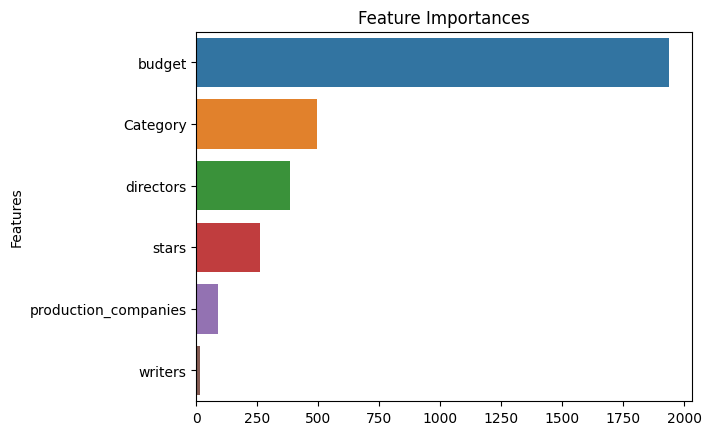

In [9]:
feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances = feature_importances[np.argsort(feature_importances)][::-1]

sns.barplot(x=feature_importances, y=X.columns, hue=X.columns)
plt.title('Feature Importances')
plt.ylabel('Features')
plt.show()

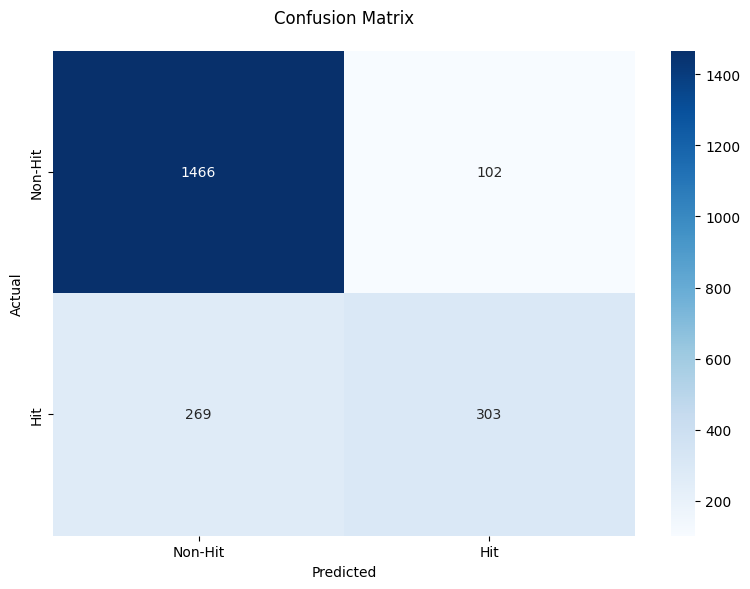

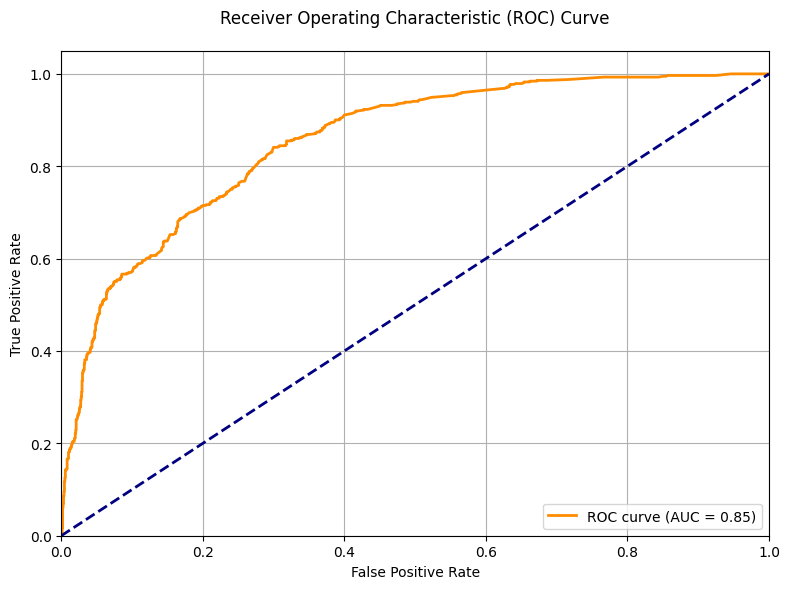

In [10]:
from sklearn.metrics import roc_curve, auc
y_pred = grid_search.predict(X_test)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'])
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve 시각화
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', pad=20)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### 예측

In [11]:
import pandas as pd
from lightgbm import LGBMClassifier

# 예측 확률 표시 함수
def predict_with_data(model:LGBMClassifier, data:pd.DataFrame, y:pd.Series):
    try:
        # 입력값 받기
        X_test = data[['budget', 'Category', 'directors', 'stars', 'production_companies', 'writers']].copy()

        # 랜덤으로 5개 데이터 선택
        sample = X_test.sample(5)

        # 예측 수행
        y_pred = model.predict(sample)
        y_pred_proba = model.predict_proba(sample)[:, 1]

        # 결과 출력
        print("\n--- Prediction Result ---")
        for idx, pred in enumerate(y_pred):
            print('-'*50)
            print("Title: ", data.iloc[sample.index[idx]]['Title'])
            print('-'*50)
            print(f"Data {idx + 1}: {'Hit' if pred == 1 else 'Not Hit'} ({y_pred_proba[idx] * 100:.2f}%)")
            print(f"Actual Value: {'Hit' if y[sample.index[idx]] == 1 else 'Not Hit'}", "예측 성공" if y[sample.index[idx]] == pred else "예측 실패", "\n")

    except ValueError:
        print("Invalid input. Please restart and provide a valid value.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
# Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 31, 'random_state': 42}
df = pd.read_csv('./Data/encoded_movies_data.csv')
df.head()

lgbm = LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=500, num_leaves=15, random_state=42)

X = df[['budget', 'Category', 'directors', 'stars', 'production_companies', 'writers']].copy()
y = df['Hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm.fit(X_train, y_train, categorical_feature=['Category', 'directors', 'stars', 'production_companies', 'writers'])

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = lgbm.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_train, lgbm.predict(X_train)), accuracy_score(y_test, y_pred))

[[1466  102]
 [ 269  303]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      1568
           1       0.75      0.53      0.62       572

    accuracy                           0.83      2140
   macro avg       0.80      0.73      0.75      2140
weighted avg       0.82      0.83      0.82      2140

0.8690420560747664 0.8266355140186916


In [14]:
predict_with_data(lgbm, df, y)


--- Prediction Result ---
--------------------------------------------------
Title:  174. Sgt. Stubby: An American Hero
--------------------------------------------------
Data 1: Not Hit (24.14%)
Actual Value: Not Hit 예측 성공 

--------------------------------------------------
Title:  500. Tru Loved
--------------------------------------------------
Data 2: Not Hit (2.94%)
Actual Value: Not Hit 예측 성공 

--------------------------------------------------
Title:  437. The Gray Man
--------------------------------------------------
Data 3: Not Hit (42.65%)
Actual Value: Not Hit 예측 성공 

--------------------------------------------------
Title:  442. Lila & Eve
--------------------------------------------------
Data 4: Not Hit (11.80%)
Actual Value: Not Hit 예측 성공 

--------------------------------------------------
Title:  311. The Romantics
--------------------------------------------------
Data 5: Not Hit (33.72%)
Actual Value: Not Hit 예측 성공 

